In [1]:
import os
import sys
import numpy as np
import gensim

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


### Post-process data

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

In [4]:
len(spectrums_postprocessed)

12797

## Import reference similarity matrices for different scores

In [5]:
filename = os.path.join(path_data,'similarities_daylight2048_jaccard.npy')
matrix_similarities_fingerprint_daylight = np.load(filename)

In [6]:
filename = os.path.join(path_data,'similarities_cosine_tol0005.npy')
matrix_similarities_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_cosine_tol0005_matches.npy')
matrix_matches_cosine = np.load(filename)

print("Matrix dimension", matrix_matches_cosine.shape)

Matrix dimension (12797, 12797)


In [14]:
# apply min_match threshold
matrix_similarities_cosine[matrix_matches_cosine < 6] = 0

In [15]:
filename = os.path.join(path_data,'similarities_mod_cosine_tol0005.npy')
matrix_similarities_mod_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_mod_cosine_tol0005_matches.npy')
matrix_matches_mod_cosine = np.load(filename)

In [16]:
# apply min_match threshold
matrix_similarities_mod_cosine[matrix_matches_mod_cosine < 10] = 0

### Load spec2vec similarities

In [7]:
filename = os.path.join(path_data, 'similarities_spec2vec_2dec_UniqueInchikeys_iter_50.npy')
matrix_similarities_spec2vec = np.load(filename)

In [21]:
former_example = ["CCMSLIB00000577509", "CCMSLIB00000577497"]

for i, spec in enumerate(spectrums_postprocessed):
    if spec.get("spectrumid") in former_example:
        print(i)

9792
9800


9792 9800
CCMSLIB00000577497 CCMSLIB00000577509
Spec2Vec score: 0.6347
Cosine score: 0.05556
Modified cosine score: 0.5509
Molecular similarity: 0.9768
0.0 1.0


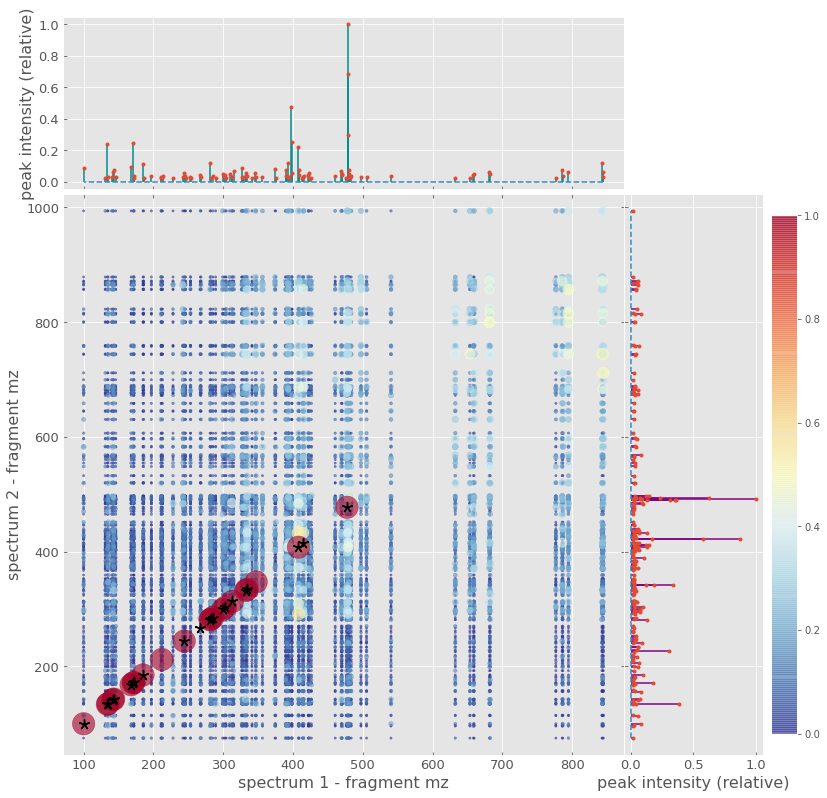

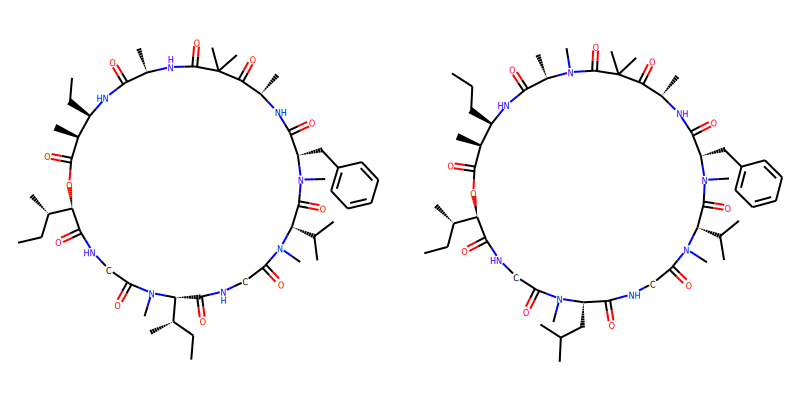

In [123]:
ID1 = 9792
ID2 = 9800
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.02,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.02,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename="example_9792_9800.pdf")#None)#

# Query the different similariy matrices
## Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [11]:
from custom_functions.plotting_functions import plot_spectra_comparison

In [74]:
pair_selection = np.where((matrix_similarities_cosine < 0.4)
                          & (matrix_similarities_mod_cosine < 0.4)
                          & (matrix_similarities_mod_cosine > 0)
                & (matrix_similarities_spec2vec > 0.85) 
                & (matrix_similarities_spec2vec < 0.98) 
                & (matrix_similarities_fingerprint_daylight > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


Found  (720,)  matching spectral pairs.


In [18]:
# Load pretrained model
model_file = os.path.join(path_data, "trained_models", "spec2vec_UniqueInchikeys_ratio05_filtered_iter_50.model")
model = gensim.models.Word2Vec.load(model_file)

In [19]:
len(model.wv.vocab)

107403

1276 1277
CCMSLIB00004679388 CCMSLIB00004679299
Spec2Vec score: 0.8577
Cosine score: 0.01642
Modified cosine score: 0.09439
Molecular similarity: 0.9801
0.0 1.0


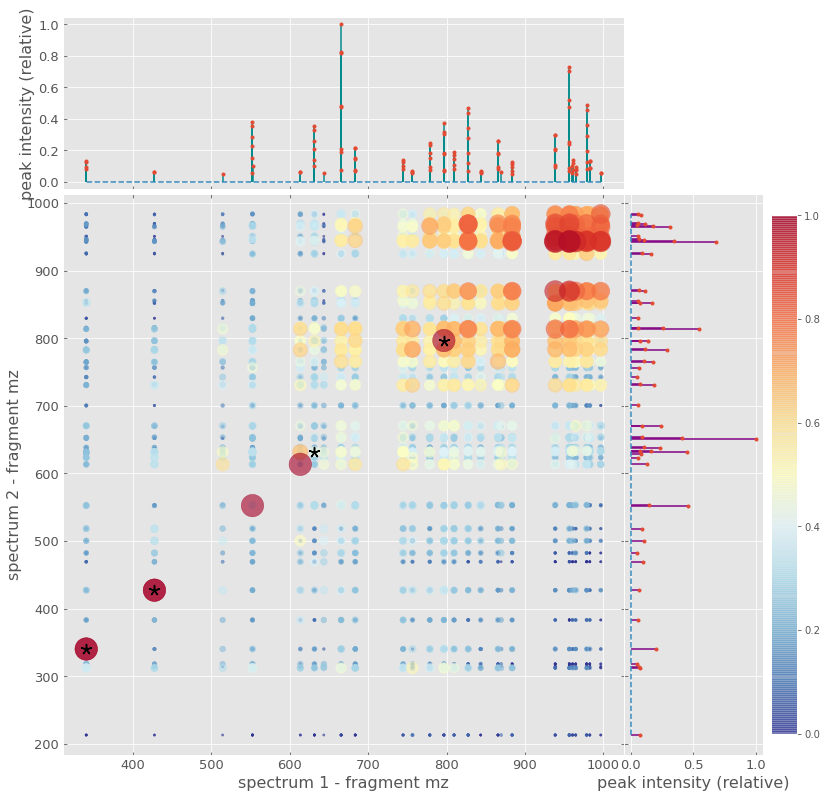

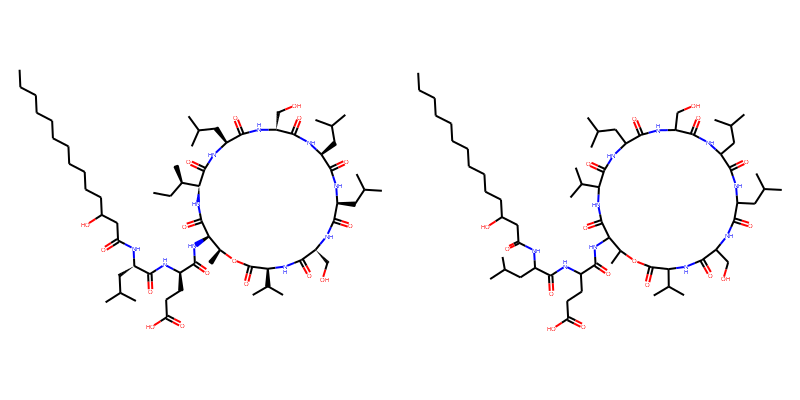

In [75]:
pick = 26 #29#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename="example_1276_1277.pdf")#None)#

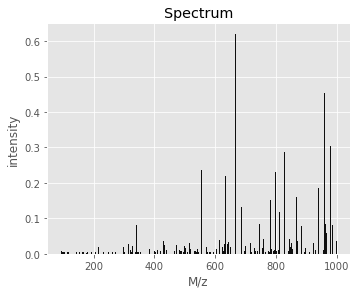

In [126]:
spectrums_postprocessed[1276].plot()
plt.savefig("spectrum_1.pdf")

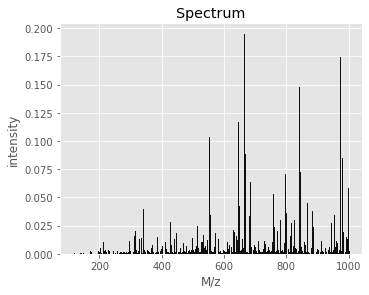

In [128]:
spectrums_postprocessed[1282].plot()
plt.savefig("spectrum_2.pdf")

In [78]:
print(spectrums_postprocessed[ID1].get("smiles") + "\n")
print(spectrums_postprocessed[ID2].get("smiles"))

CCCCCCCCCCCC(CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@@H]1[C@@H](OC(=O)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H](NC1=O)[C@H](C)CC)CC(C)C)CO)CC(C)C)CC(C)C)CO)C(C)C)C)O

CCCCCCCCCCCC(O)CC(NC(C(NC(C(NC1C(C)OC(C(C(C)C)NC(C(CO)NC(C(CC(C)C)NC(C(CC(C)C)NC(C(CO)NC(C(CC(C)C)NC(C(C(C)C)NC1=O)=O)=O)=O)=O)=O)=O)=O)=O)CCC(O)=O)=O)CC(C)C)=O


In [102]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

from matplotlib import pyplot as plt

In [107]:
# Test in a kinase inhibitor
molecules = [Chem.MolFromSmiles(spectrums_postprocessed[ID1].get("smiles")),
             Chem.MolFromSmiles(spectrums_postprocessed[ID2].get("smiles"))]
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(800, 800))
with open('grid.svg', 'w') as f:
    f.write(img.data)

1276 1279
CCMSLIB00004679388 CCMSLIB00004679301
Spec2Vec score: 0.8276
Cosine score: 0.04253
Modified cosine score: 0.112
Molecular similarity: 0.9801
0.0 1.0


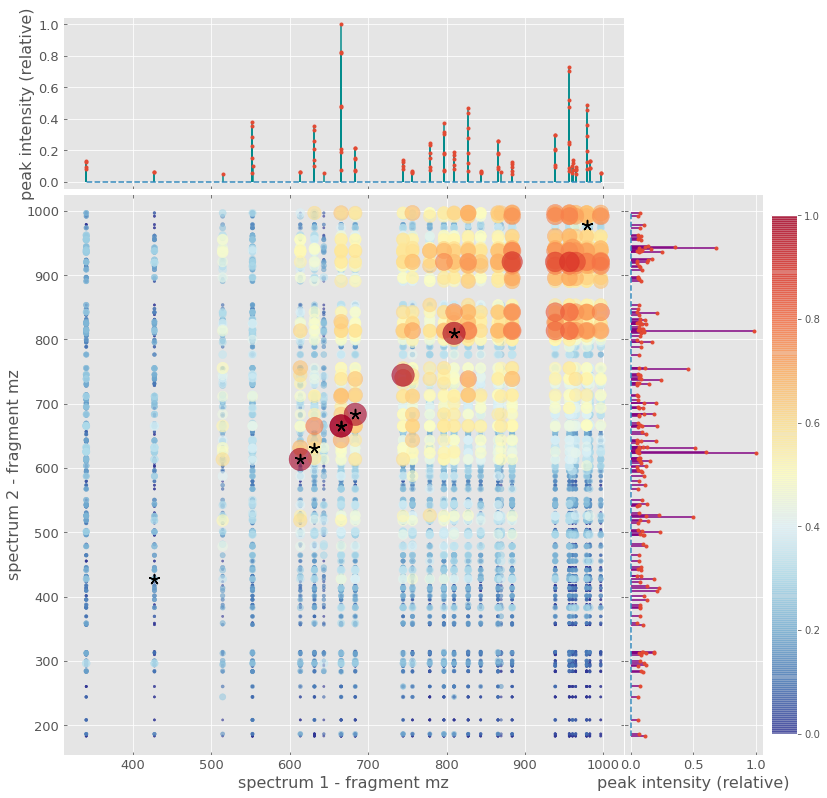

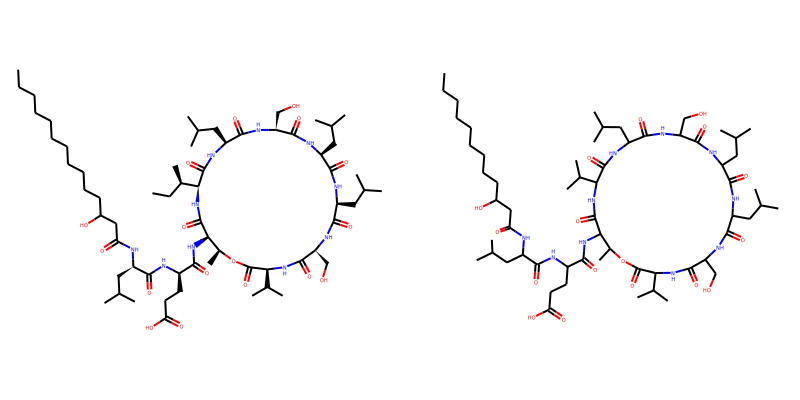

In [118]:
#pick = 28#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = 1276#pair_selection[0][pick]
ID2 = 1279#pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_1276_1277.pdf")#

1276 1282
CCMSLIB00004679388 CCMSLIB00004679304
Spec2Vec score: 0.8607
Cosine score: 0.065
Modified cosine score: 0.07474
Molecular similarity: 0.9801
0.0 1.0


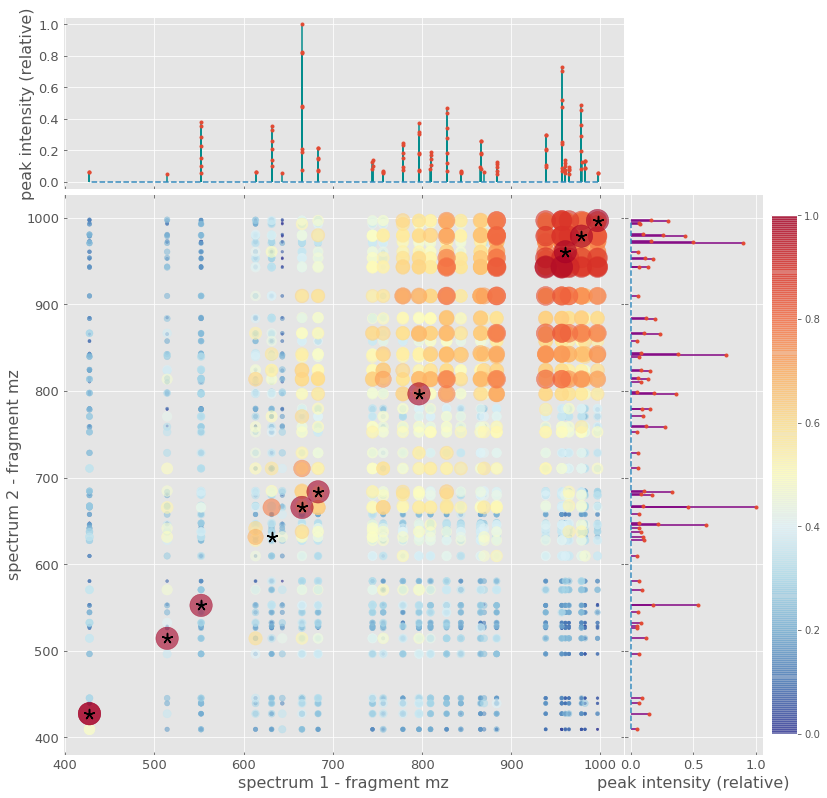

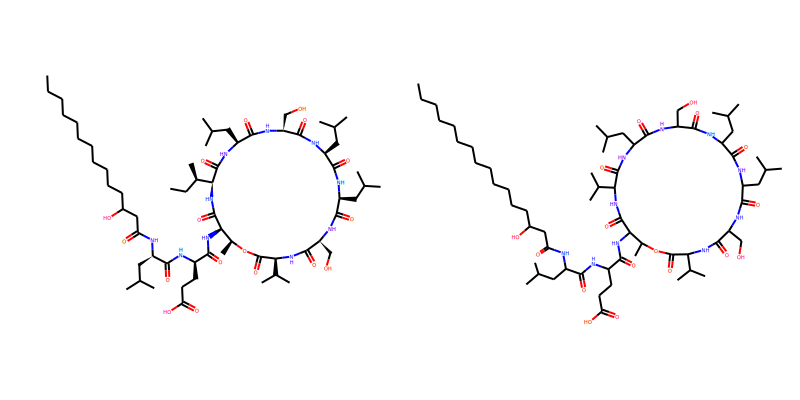

In [122]:
pick = 28#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=400,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename="example_1276_1282_300-1000.pdf")#None)#

In [120]:
# Test in a kinase inhibitor
molecules = [Chem.MolFromSmiles(spectrums_postprocessed[ID1].get("smiles")),
             Chem.MolFromSmiles(spectrums_postprocessed[ID2].get("smiles"))]
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(800, 800))
with open('molecules_1276_1282.svg', 'w') as f:
    f.write(img.data)

# Query the different similariy matrices
## Example for: cosine=mid-low, molnet=mid, word2vec=high, molecular similarity=high

In [185]:
matrix_similarities_fingerprint_daylight[np.isnan(matrix_similarities_fingerprint_daylight)] = 0

In [33]:
pair_selection = np.where((matrix_similarities_cosine < 0.5)
                          & (matrix_similarities_mod_cosine < 0.5)
                & (matrix_similarities_spec2vec > 0.85) 
                & (matrix_similarities_spec2vec < 0.98) 
                & (matrix_similarities_fingerprint_daylight > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Found  (2266,)  matching spectral pairs.


11195 11218
CCMSLIB00000214869 CCMSLIB00000215010
Spec2Vec score: 0.895
Cosine score: 0.0
Modified cosine score: 0.0
Molecular similarity: 0.9267
0.0 1.0


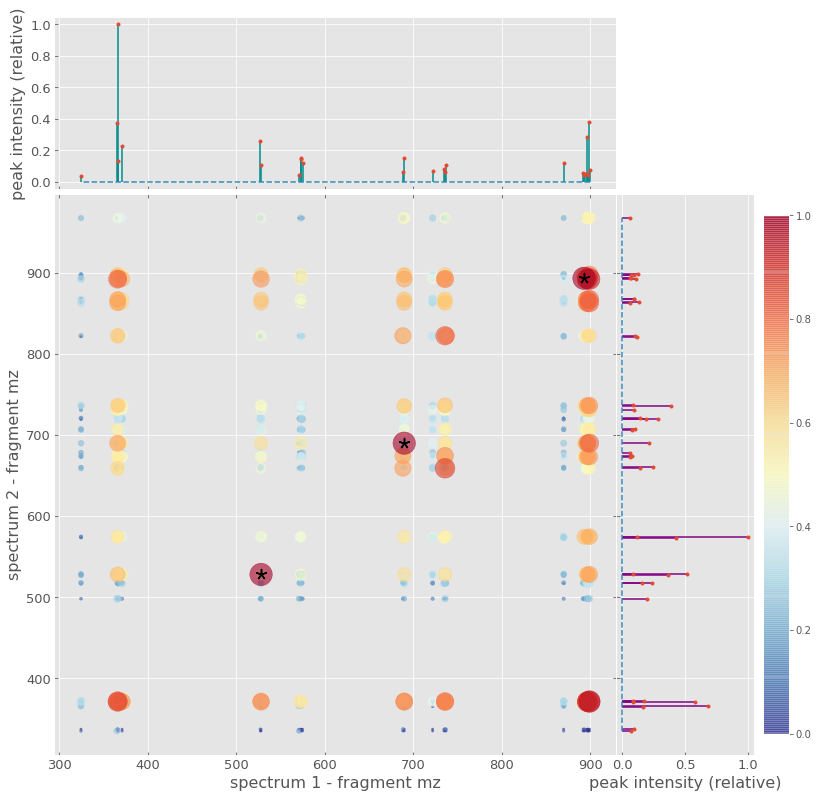

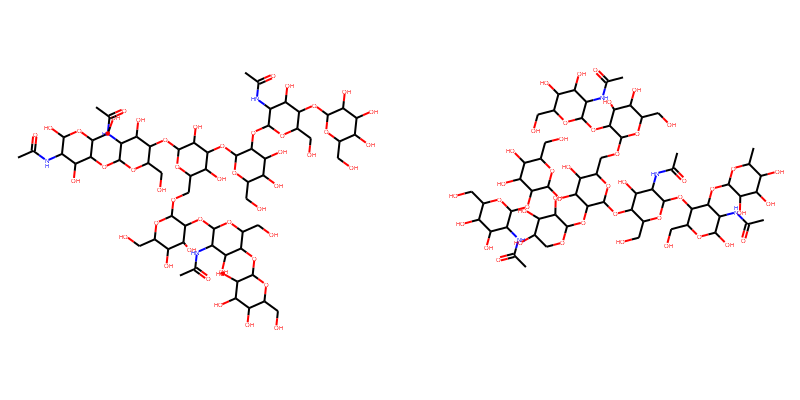

In [72]:
pick = 2050
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.02,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")

9921 9884
Spec2Vec score: 0.8928
Cosine score: 0.435
Modified cosine score: 0.435
Molecular similarity: 1.0
0.0 1.0


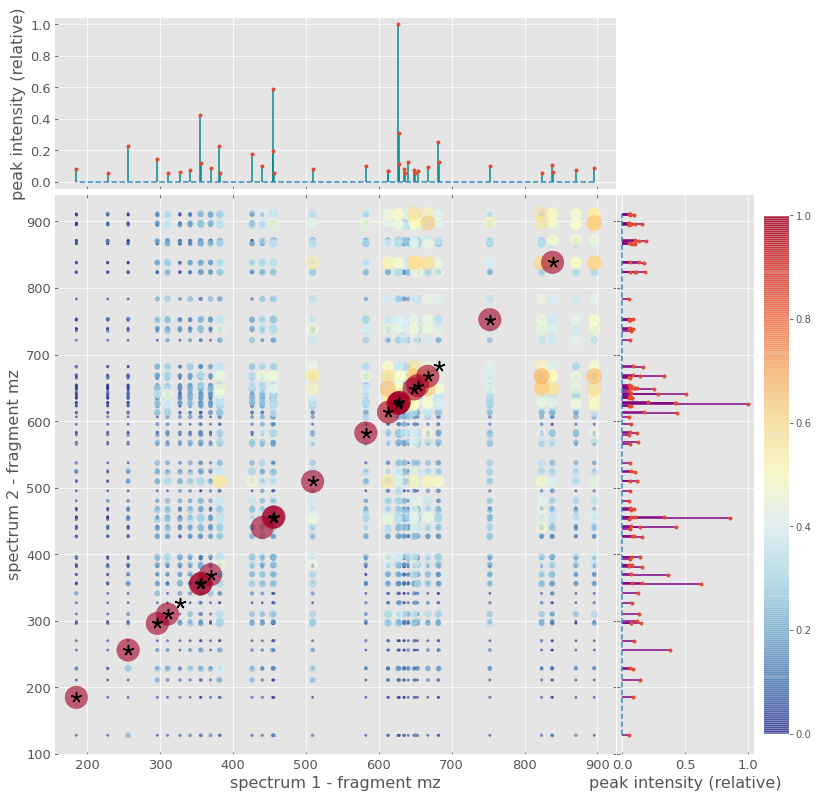

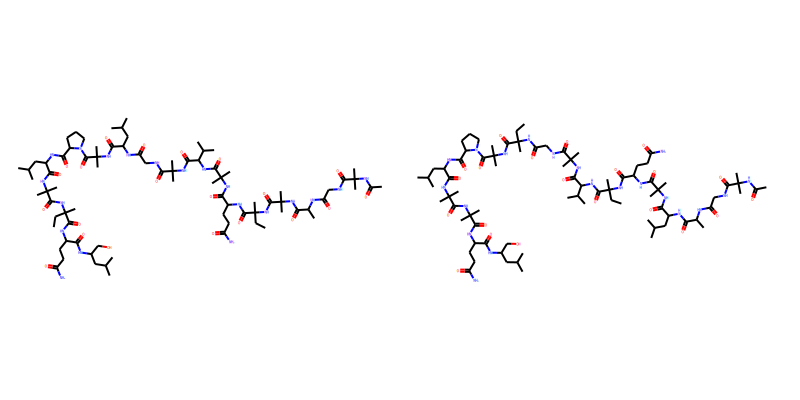

In [225]:
pick = 170
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")

# Query the different similariy matrices
## Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [232]:
pair_selection = np.where((matrix_similarities_cosine > 0.7)
                          & (matrix_similarities_mod_cosine > 0.7)
                          & (matrix_similarities_spec2vec < 0.4) 
                          & (matrix_similarities_fingerprint_daylight < 0.3))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (268,)  matching spectral pairs.


2393 6987
Spec2Vec score: 0.399
Cosine score: 0.8094
Modified cosine score: 0.8099
Molecular similarity: 0.2318
0.0 1.0


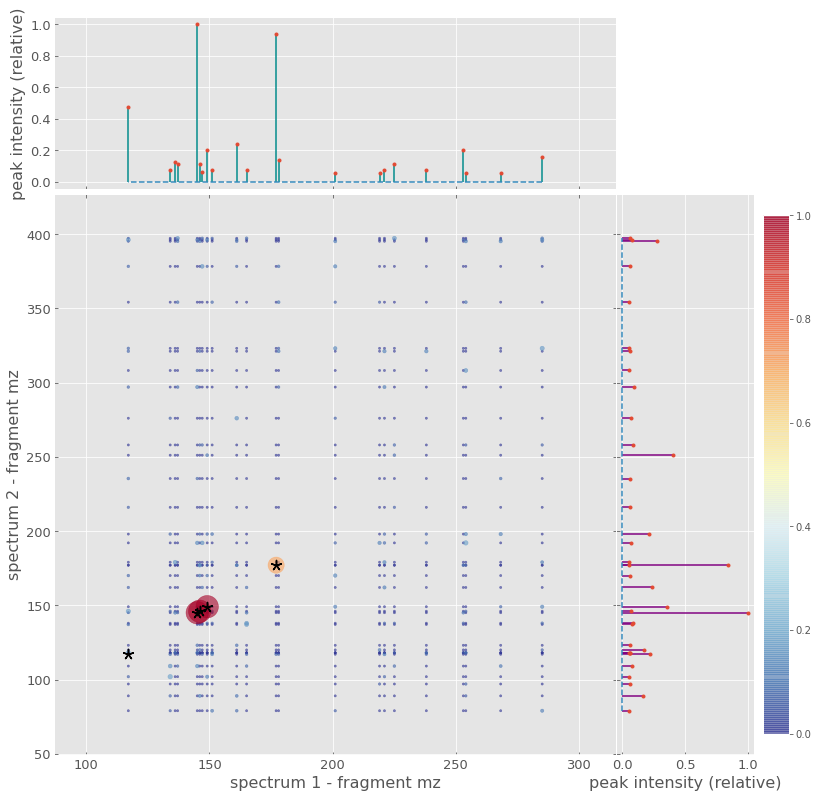

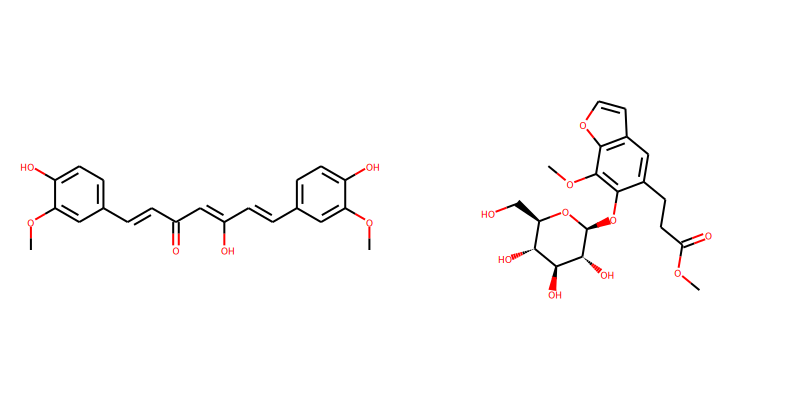

In [233]:
pick = 20
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")